# Week 5: Classification

In this section we will apply what we have learned about the logistic regression model to fit a model and make predictions. We will be using the `penguins` dataset from `seaborn` and try to predict whether or not a penguin is of Adelie species.

We will build a Logistic Regression model from scratch.


In [1]:
# Code for Week 5
import pandas as pd
import numpy as np
import seaborn as sns

# Import penguins
penguins = (sns.load_dataset("penguins")).dropna()
penguins["One"] = 1
penguins["Adelie"] = 1*(penguins["species"] == "Adelie")

print("Data Shape, ",penguins.shape)

# Take a look at the columns
print(penguins.head())

# What percentage of our data is Adelie
print(np.mean(penguins.Adelie))

# What features do we have
print(penguins.columns)


Data Shape,  (333, 9)
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  One  Adelie  
0       3750.0    MALE    1       1  
1       3800.0  FEMALE    1       1  
2       3250.0  FEMALE    1       1  
4       3450.0  FEMALE    1       1  
5       3650.0    MALE    1       1  
0.43843843843843844
Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'One', 'Adelie'],
      dtype='object')


## Setting up our Model

In this example, we will use the features "bill_length_mm", "bill_depth_mm", "flipper_length_mm", and "body_mass_g" to predict whether or not the species is Adelie.

In [2]:

X = penguins[['One','bill_length_mm', 'bill_depth_mm','flipper_length_mm','body_mass_g']]
Y = penguins['Adelie']

peng


Recall that in logistic regression, we model the probability as 

$$ \pi(\mathbf{X}_i; \boldsymbol{\beta}) = \frac{1}{1 + \exp\left(-\beta_0 - \beta_1 X_{i,1} - \dots - \beta_p X_{i,p}\right)}$$


To make predictions with this model (and evaluate the gradient) we will first need to write a function that takes in our feature matrix and a guessed value of $\boldsymbol\beta$ and returns a vector of probabilities. 




In [11]:
def LogitReg(Xtrain, beta):
    power = -1*np.dot(Xtrain,beta)
    pHat = 1/(1 + np.exp(power))
    return pHat

beta_initial = np.array((-0.001,0.001,0.001,-0.001,0.001))
test = LogitReg(X,beta_initial)
print(test)


[0.97406286 0.97515403 0.95739727 0.96483819 0.97122077 0.97067923
 0.9894163  0.95587919 0.9751031  0.98602897 0.97257254 0.96482802
 0.98744746 0.96056243 0.98325057 0.96377471 0.96997966 0.97503747
 0.97854901 0.9752773  0.97506423 0.96848288 0.95565513 0.9540648
 0.97871838 0.95800088 0.9776057  0.95962377 0.97757284 0.96016656
 0.9822472  0.97849647 0.96861995 0.95987872 0.98926975 0.95353603
 0.9773171  0.9510841  0.98616743 0.94623661 0.98865311 0.96450078
 0.96486871 0.98238963 0.96676333 0.98478288 0.9648348  0.98036286
 0.94073263 0.97256187 0.96830843 0.97504477 0.93826029 0.97370424
 0.95331845 0.98616197 0.96978102 0.98047421 0.9381095  0.9784712
 0.96104822 0.98149798 0.948412   0.98677326 0.96957225 0.9774034
 0.96800941 0.9823064  0.9724013  0.98394106 0.97250043 0.97750257
 0.96814847 0.97947152 0.95528924 0.98968206 0.97509582 0.9830518
 0.96132429 0.96821932 0.97503017 0.96660875 0.97849016 0.96972529
 0.9677264  0.98452906 0.96321194 0.98688375 0.95951514 0.98449094

We will also want a function that takes in the predicted probabilitis and returns the evaluates the log-likelihood:

$$ \ell(\boldsymbol\beta) = \sum_{i=1}^n Y_i\ln\pi\left(\mathbf{X}_i ;\boldsymbol{\beta}\right) + (1 - Y_i)\ln(1 - \pi(\mathbf{X}_i;\boldsymbol{\beta}))$$

In [12]:
def LogitLikelihood(Ytrain, pHat):
    return 1/(len(Ytrain))*np.sum(Ytrain*np.log(pHat) + (1 - Ytrain)*np.log(1 -pHat))
    
test2 = LogitLikelihood(Y,test)
print(test2)

-2.5221444759399567


We will find the parameters $\beta_0, \beta_1,...,\beta_p$ to maximize the (simplified) log-likelihood:
$$ \ell(\boldsymbol{\beta}) = \sum_{i=1}^n \left[\ln\left\{1 + e^{\boldsymbol{\beta}\mathbf{X}_i}\right\} - Y_i\boldsymbol\beta\mathbf{X}_i\right] $$

The gradient of $\ell(\boldsymbol\beta)$ is given:

$$\nabla \ell(\boldsymbol{\beta}) = \left[\mathbf{Y}-\tilde\pi(\mathbf{X};\boldsymbol{\beta})\right]\cdot\mathbf{X}$$

where:
$$\tilde{\pi}(\mathbf{X};\boldsymbol{\beta}) = \left(\pi(\mathbf{X}_i;\boldsymbol{\beta}),\dots, \pi(\mathbf{X}_n;\boldsymbol{\beta})\right)'$$ denotes our vector of predicted probabilities at guess $\boldsymbol{\beta}$

In order to implement this, we will need to write a gradient descent function. We can use what we have above:

In [13]:

def LogitGradientDescent(beta_initial, num_iterations, gamma, Xtrain, Ytrain):
    # Set up for gradient descent
    beta = beta_initial
    likelihoods = []
    # Do the gradient descent (updating each time)
    for i in range(num_iterations):
        # Find the vector of probabilities
        pHat = LogitReg(Xtrain, beta)
        # Evaluate the log-likelihood function
        likelihood = LogitLikelihood(Ytrain, pHat)
        # Add the likelihood to the list
        likelihoods.append(likelihood)
        # Compute the gradient
        grad = (1/len(Ytrain))*np.dot(Ytrain - pHat, Xtrain)
        # Update Beta
        beta = beta + gamma*grad
    # Compute the likelihood for the final value of beta
    pHat = LogitReg(Xtrain, beta)
    likelihood = LogitLikelihood(Ytrain, pHat)
    likelihoods.append(likelihood)
    # Return the last value of beta and the likelihoods
    return beta, np.array(likelihoods)

from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, random_state = 0)


num_iterations = 10000
gamma = 0.0000001

betaFinal, likelihoods = LogitGradientDescent(beta_initial, num_iterations, gamma, Xtrain, Ytrain)
print(betaFinal)


[-0.00095601  0.00080566  0.00223056  0.00371919 -0.00031447]


Now we plot the convergence curve:

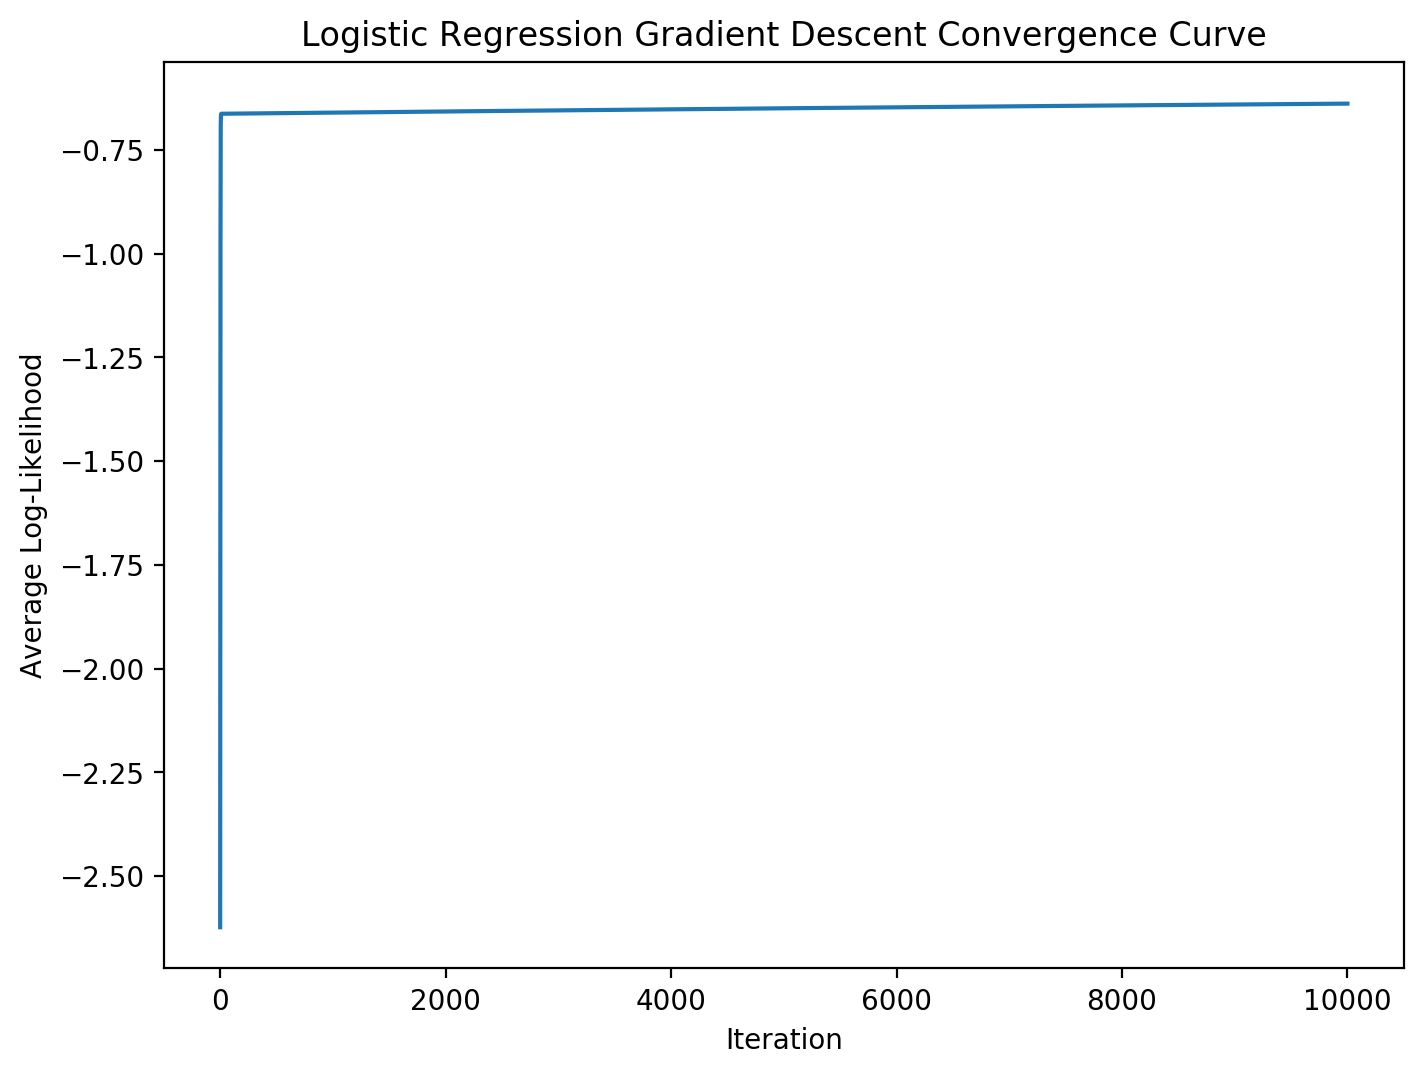

In [14]:
import matplotlib.pyplot as plt
x = np.arange(len(likelihoods))
a = plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k') 
a = plt.title("Logistic Regression Gradient Descent Convergence Curve")
a = plt.ylabel("Average Log-Likelihood")
a = plt.xlabel("Iteration")
a = plt.plot(x,likelihoods)
a = plt.savefig("Convergence Curve")

And assess the preformance of our model

In [15]:
pHatFinal = LogitReg(Xtest,betaFinal)
Yhat = 1*(pHatFinal >= 0.5)
accuracy = np.mean(Yhat == Ytest)
print(accuracy)

0.5


How does this compare to the linear model?

In [16]:
from sklearn.linear_model import LinearRegression 
model = LinearRegression()
model.fit(Xtrain,Ytrain)
test = model.predict(Xtest)
YHatLinear = 1*(test >= 0.5)
linearAccuracy = np.mean(YHatLinear == Ytest)
print(linearAccuracy)



0.9761904761904762


#### Machine Learning is hard 
